In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("C:/Users/SAI VAMSHI/Desktop/MSU MSBA/Stout Case Study")

Reading the csv file pertaining to second case study

In [4]:
df = pd.read_csv("casestudy.csv")
df.head()

,Unnamed: 0,customer_email,net_revenue,year
0,0,nhknapwsbx@gmail.com,249.92,2015
1,1,joiuzbvcpn@gmail.com,87.61,2015
2,2,ukkjctepxt@gmail.com,168.38,2015
3,3,gykatilzrt@gmail.com,62.40,2015
4,4,mmsgsrtxah@gmail.com,43.08,2015


In [8]:
df.isnull().sum()

Unnamed: 0        0
customer_email    0
net_revenue       0
year              0
dtype: int64

The variable descriptions are
* *customer_email* - Unique identifier for a customer
* *net_revenue* - Revenue generated because of the customer during a particular year
* *year* - Year

According to the description, we can make a hypothesis that the unique key of this dataset is customer_email x year assuming only one row for one customer in one year. Let's prove the assumption by writing a small piece of code

In [5]:
df.shape

(685927, 4)

In [9]:
sum(df.groupby(["customer_email","year"])["net_revenue"].count()==1)/df.shape[0]

1.0

In [11]:
print(529471/(604618))
print(68985/(604618))
print(6162/(604618))

0.875711606336563
0.114096834695626
0.010191558967811081


In [10]:
df.customer_email.nunique()

604618

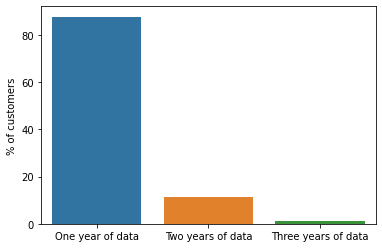

In [15]:
sns.barplot(x=["One year of data","Two years of data","Three years of data"],y=[87.6,11.4,1])
plt.ylabel("% of customers")
plt.show()

From the above result we can tell that there is only observation for one year for one customer.

Let's check whether customers data is present for all the possible years

In [9]:
df.groupby(["customer_email"])["Unnamed: 0"].count().value_counts()

1    529471
2     68985
3      6162
Name: Unnamed: 0, dtype: int64

6162 customers have 3 years of data, 68985 customers have 2 years of data and 529471 customers have only 1 year of data.

Let's make a simple visualization to check the years and revenue in each year

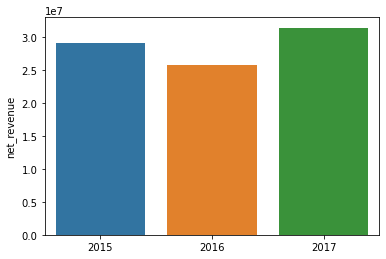

In [16]:
sns.barplot(x=df.year.unique(),y=df.groupby(["year"])["net_revenue"].sum())
plt.show()

The above plot suggests that there are three years available in the data and 25M-30M revenue each year.

Let's take the required information using Python codes

## Total Revenue for the current year

In [17]:
df.groupby(["year"])["net_revenue"].sum().reset_index()

,year,net_revenue
0,2015,29036749.19
1,2016,25730943.59
2,2017,31417495.03


## New Customer Revenue e.g. new customers not present in previous year only

We cannot calculate the new customer revenue of 2015 as we don't know the prior data.

Also, a customer is considered new even if there are sales in 2015 but no sales in 2016 and again sales in 2017 as suggested from the question

In [118]:
df = df.sort_values(["customer_email", "year"])
df["yeardiff"] = df.groupby("customer_email")["year"].diff().fillna(0)

If the difference of years between consecutive observations is 0, we can assume that the customer is new customer. For 2016 and 2017 years, we can calculate the new customer revenue

In [123]:
df[df.yeardiff==0].groupby("year")["net_revenue"].sum().tail(2)

year
2016    18245491.01
2017    28676607.64
Name: net_revenue, dtype: float64

The above analysis takes lot of memory and space. We can calculate new customer revenue using an easy method as below

In [117]:
#Getting the minimum year of every customer and a customer is new if the min year is equal to current year
df_minyear = pd.merge(df,df.groupby(["customer_email"])["year"].min().reset_index(),on="customer_email").drop_duplicates()
df_minyear[df_minyear.year_x==df_minyear.year_y].groupby(["year_x"])["net_revenue"].sum().reset_index().tail(2)

,year_x,net_revenue
1,2016,18245491.01
2,2017,28676607.64


## Existing Customer Growth, Revenue of existing customers for current year – Revenue of existing customers from existing year

We can only calculate customer growth for 2016 and 2017 years and old customers.

In [126]:
#Revenue of existing customers for current year
revenue_currentyear = df[df.yeardiff==1].groupby("year")["net_revenue"].sum()
#Revenue of existing customers for existing year
df["nextyear"] = df["year"] + 1
df_existing = pd.merge(df,df_minyear[df_minyear.year_x!=df_minyear.year_y][["customer_email","year_x"]].drop_duplicates(),left_on=["customer_email","nextyear"],right_on=["customer_email","year_x"])
revenue_existingyear = df_existing.groupby("nextyear")["net_revenue"].sum()
#Revenue growth
revenue_currentyear - revenue_existingyear

year
2016    20335.46
2017    20611.34
Name: net_revenue, dtype: float64

We can do the above analysis using another method but it takes lot of memory and time

In [128]:
df = df.sort_values(["customer_email", "year"])
df["rev_growth"] = df.groupby(["customer_email"])["net_revenue"].diff().fillna(0)
df[df.yeardiff==1].groupby("year")["rev_growth"].sum()

year
2016    20335.46
2017    20611.34
Name: rev_growth, dtype: float64

## Revenue lost from attrition

To get revenue lost from attrition, we have to make an assumption that the customers attrited will generated same amount of sales if they haven't attrited.

In [113]:
#Customers whose max year is the current year are the customers who got attrited
df_maxyear = pd.merge(df,df.groupby(["customer_email"])["year"].max().reset_index(),on="customer_email").drop_duplicates()
df_maxyear[df_maxyear.year_x==df_maxyear.year_y].groupby(["year_x"])["net_revenue"].sum().reset_index().head(2)

,year_x,net_revenue
0,2015,2.147600e+07
1,2016,2.311029e+07


Since we don't know the 2018 data, we have to ignore 2017 attrition revenue

So the total revenue lost from attrition across 2015 and 2016 is ~45M (22 in 2015+23 in 2016)

## Existing Customer Revenue Current Year

Since we can know whether a customer is a new or old for 2016 and 2017 years only, the data is present for 2 years

In [127]:
df[df.yeardiff==1].groupby("year")["net_revenue"].sum()

year
2016    7485452.58
2017    2641259.99
Name: net_revenue, dtype: float64

## Existing Customer Revenue Prior Year

In [99]:
df["nextyear"] = df["year"] + 1
df_existing = pd.merge(df,df_minyear[df_minyear.year_x!=df_minyear.year_y][["customer_email","year_x"]].drop_duplicates(),left_on=["customer_email","nextyear"],right_on=["customer_email","year_x"])
df_existing.groupby("nextyear")["net_revenue"].sum()

nextyear
2016    7465117.12
2017    2620648.65
Name: net_revenue, dtype: float64

## Total Customers Current Year

In [105]:
df.groupby(["year"])["customer_email"].count()

year
2015    231294
2016    204646
2017    249987
Name: customer_email, dtype: int64

## Total Customers Previous Year

In [114]:
df.groupby(["year"])["customer_email"].count().shift(1).tail(2)

year
2016    231294.0
2017    204646.0
Name: customer_email, dtype: float64

## New Customers

We can do this in the same way as we calculated new customer revenue

In [115]:
df_minyear = pd.merge(df,df.groupby(["customer_email"])["year"].min().reset_index(),on="customer_email").drop_duplicates()
df_minyear[df_minyear.year_x==df_minyear.year_y].groupby(["year_x"])["customer_email"].count().reset_index().tail(2)

,year_x,customer_email
1,2016,145062
2,2017,228262


## Lost Customers

We can do this in the same way as we calculated revenue lost from attrition

In [116]:
df_maxyear = pd.merge(df,df.groupby(["customer_email"])["year"].max().reset_index(),on="customer_email").drop_duplicates()
df_maxyear[df_maxyear.year_x==df_maxyear.year_y].groupby(["year_x"])["customer_email"].count().reset_index().head(2)

,year_x,customer_email
0,2015,170944
1,2016,183687


We have to remove the 2017 value as we don't know whether the customer is lost or not

Let's get all the results into one table

In [131]:
q1 = df.groupby(["year"])["net_revenue"].sum()
q2 = df_minyear[df_minyear.year_x==df_minyear.year_y].groupby(["year_x"])["net_revenue"].sum().tail(2)
q3 = (revenue_currentyear - revenue_existingyear)
q4 = df_maxyear[df_maxyear.year_x==df_maxyear.year_y].groupby(["year_x"])["net_revenue"].sum().head(2)
q5 = df[df.yeardiff==1].groupby("year")["net_revenue"].sum()
q6 = df_existing.groupby("nextyear")["net_revenue"].sum()
q7 = df.groupby(["year"])["customer_email"].count()
q8 = df.groupby(["year"])["customer_email"].count().shift(1).tail(2)
q9 = df_minyear[df_minyear.year_x==df_minyear.year_y].groupby(["year_x"])["customer_email"].count().tail(2)
q10 = df_maxyear[df_maxyear.year_x==df_maxyear.year_y].groupby(["year_x"])["customer_email"].count().head(2)


In [137]:
final_data = pd.concat([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10],axis=1)
final_data.columns = ["Total Revenue Current Year",
                      "New Customer Revenue",
                      "Existing Customer Growth",
                      "Revenue lost from attrition",
                      "Existing customer revenue current year",
                      "Existing customer revenue previous year",
                      "Total customers current year",
                      "Total customers previous year",
                      "New Customers",
                      "Lost Customers"]

In [138]:
final_data

,Total Revenue Current Year,New Customer Revenue,Existing Customer Growth,Revenue lost from attrition,Existing customer revenue current year,Existing customer revenue previous year,Total customers current year,Total customers previous year,New Customers,Lost Customers
2015,29036749.19,NaN,NaN,2.147600e+07,NaN,NaN,231294,NaN,NaN,170944.0
2016,25730943.59,18245491.01,20335.46,2.311029e+07,7485452.58,7465117.12,204646,231294.0,145062.0,183687.0
2017,31417495.03,28676607.64,20611.34,NaN,2641259.99,2620648.65,249987,204646.0,228262.0,NaN


In [2]:
import os
os.chdir("C:/Users/SAI VAMSHI/Desktop/MSU MSBA/Stout Case Study")
os.system('jupyter nbconvert --to html Question2.ipynb')

0